In [1]:
import numpy as np
import pandas as pd

import tensorflow
import keras
from keras import optimizers
from keras import losses, regularizers
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, Dense, Flatten, Activation
from keras.layers import UpSampling1D, MaxPooling1D, ZeroPadding1D

from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard, ModelCheckpoint


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns
import sys
import os
import glob

In [41]:
class Visualization:
    labels = ["Normal", "Anomaly"]
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y_true=y, y_pred=y_pred)
        
        plt.figure(figsize=(7,5))
        colors =['orange', 'green']
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels,
                   cmap=colors, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error':error, 'true':y}).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, linestyle='',
                      marker='x' if name == 1 else 'o',
                      color='r' if name == 1 else 'g',
                      label='Anomaly' if name == 1 else 'Normal'
                      )
        axes.hlines(threshold, xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1],
                   colors='b', zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    def draw_error(self, error, threshold):
        figure, axes = plt.subplots(figsize=(12, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        plt.hlines(threshold, xmin=0, xmax=len(error)-1,
                   colors='b', zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
        

In [3]:
data_folder = os.path.join('D:', os.sep, 'datasets')
print(data_folder)

D:\datasets


In [4]:
# !unzip creditcard.zip
# print(f.filename)

In [5]:
df = pd.read_csv(os.path.join(data_folder, 'creditcard.csv'), index_col=None)

In [6]:
print(f'data shape: {df.shape}')
df.head()

data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# df.info()

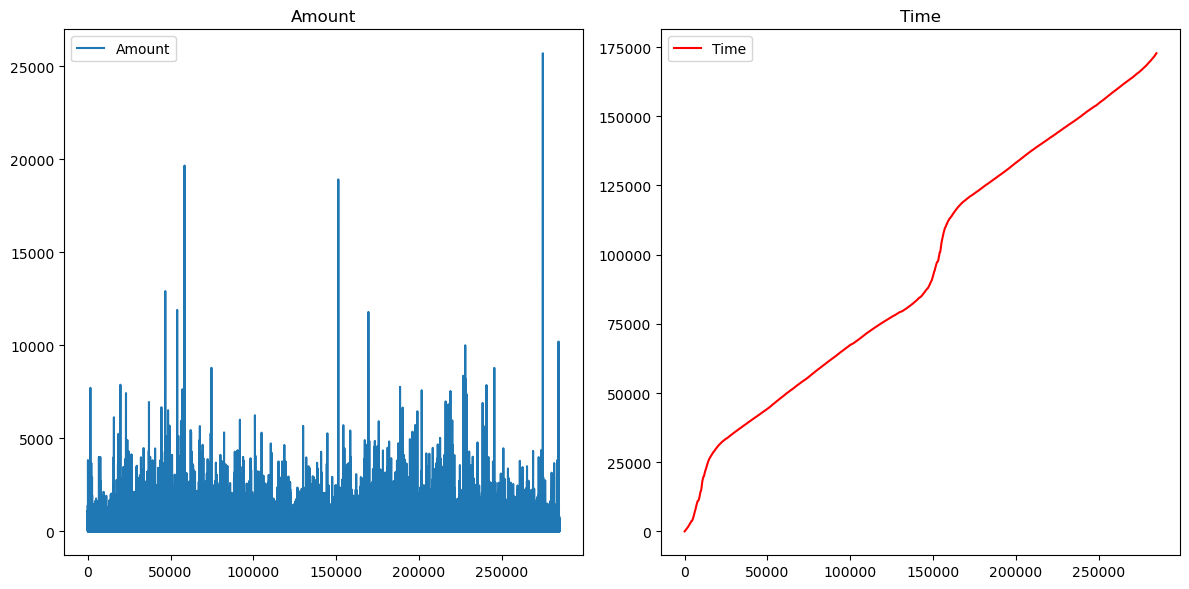

In [8]:
# df['Time'].describe()
# fig, ax = plt.subplots(nrows=1, ncols=2)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(df['Amount'], label='Amount')
plt.legend()
plt.title("Amount")

plt.subplot(1, 2, 2)
plt.plot(df['Time'], c='r',label='Time')
plt.legend()
plt.title("Time")

plt.tight_layout()

### Scale desired data

In [9]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [10]:
df[['Amount', 'Time']].describe()

,Amount,Time
count,2.848070e+05,2.848070e+05
mean,2.913952e-17,-3.065637e-16
std,1.000002e+00,1.000002e+00
min,-3.532294e-01,-1.996583e+00
25%,-3.308401e-01,-8.552120e-01
50%,-2.652715e-01,-2.131453e-01
75%,-4.471707e-02,9.372174e-01
max,1.023622e+02,1.642058e+00


### Shuffle and split data

In [11]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape

((492, 31), (284315, 31))

In [12]:
for i in range(0, 20):
    # np.random.permutation: Randomly permute a sequence
    normal = normal.iloc[np.random.permutation(len(normal))]

In [13]:
dataset = pd.concat([normal[:10000], anomalies])

x_train, x_test = train_test_split(dataset, test_size=0.4, random_state=101)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train['Class'].copy()
y_test = x_test['Class'].copy()


# x_train.drop('Class', axis=1, inplace=True)
# x_test.drop('Class', axis=1, inplace=True)



In [14]:
x_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
36,-1.996014,-0.246046,0.473267,1.695738,0.262411,-0.010866,-0.610836,0.793937,-0.247253,0.138879,...,-0.194600,-0.335133,-0.078180,0.392784,-0.031157,0.198037,-0.175347,-0.203616,-0.231328,0
73,-1.995572,-0.580629,0.482684,1.333123,-0.253080,-0.028469,-0.519166,0.503249,0.117773,0.117112,...,-0.042142,-0.148707,0.001451,0.302764,-0.680714,-0.015554,-0.006307,0.164222,-0.266631,0
111,-1.995046,1.148187,0.085837,0.120702,1.126665,0.214711,0.537381,-0.049989,0.186175,0.111781,...,-0.091112,-0.095475,-0.166750,-0.653433,0.713020,-0.288035,0.031507,0.000372,-0.274187,0
127,-1.994898,-0.655264,0.409899,1.289156,-0.325043,0.545669,-0.349811,0.648240,0.036063,0.078701,...,-0.155727,-0.477390,-0.126525,-0.443628,-0.012118,0.143173,0.049783,0.118280,-0.223252,0
128,-1.994898,-3.007739,0.929514,-0.423721,-1.392952,0.082247,-0.515782,0.104714,0.825311,0.385453,...,-0.409246,-0.588832,0.068045,-0.890870,-0.047641,0.717617,-0.054094,-0.424260,-0.193506,0


In [15]:
# Normal and anomalouse Classes comparison
x_train['Class'].value_counts()

0    5996
1     299
Name: Class, dtype: int64

In [16]:
print("Shapes:")
print("x_train:%s \ny_train :%s \n" % (x_train.shape, y_train.shape))
print("x_test:%s \ny_test: %s \n" % (x_test.shape, y_test.shape))

Shapes:
x_train:(6295, 31) 
y_train :(6295,) 

x_test:(4197, 31) 
y_test: (4197,) 



**To pass the data sets into the CONVOLUTIONAL model:</BR></BR>
1- the x sets must be 3-d, (num of samples, data rows, data cols)</BR></BR>
2- the y sets must be 2-d (OneHot Matrix for output)**

In [17]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}\n')
print(f'input shape: {input_shape}')

x_train shape: (6295, 31, 1)
x_test shape: (4197, 31, 1)

input shape: (31, 1)


In [18]:
x_train[0].shape

(31, 1)

In [19]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (6295, 2)
y_test shape: (4197, 2)


In [20]:
# as you see below the y is a one hot matrix for label.
y_train[1:18]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [21]:
input_layer = Input(shape=(input_shape ))

### ENCODING STAGE
# Pairs of causal 1D convolutional layers and pooling layers comprising the encoding stage
conv_1 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

pool_1 = MaxPooling1D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv1D(filters=int(input_shape[0] / 2), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_1)

pool_2 = MaxPooling1D(pool_size=2, strides=3)(conv_2)

conv_3 = Conv1D(filters=int(input_shape[0] / 3), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_2)


### OUTPUT OF ENCODING STAGE
encoder = Dense(int(input_shape[0] / 6), activation='relu')(conv_3)

In [22]:
### DECODING STAGE
# Pairs of upsampling and causal 1D convolutional layers comprising the decoding stage
upsample_1 = UpSampling1D(size=3)(encoder)

conv_4 = Conv1D(filters=int(input_shape[0]/3), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(upsample_1)

upsample_2 = UpSampling1D(size=2)(conv_4)

conv_5 = Conv1D(filters=int(input_shape[0]/2), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(upsample_2)

zero_pad_1 = ZeroPadding1D(padding=(0,1))(conv_5)

conv_6 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(zero_pad_1)


### Output of decoding stage flattened and passed through softmax to make predictions
flat = Flatten()(conv_6)

output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

In [23]:
TCN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizers.Adam(learning_rate=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath="model_ED_TCN_creditcard.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 31, 31)            93        
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 31)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 15)            945       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 15)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 10)             310   

In [24]:
history = TCN.fit(x_train, y_train,
                  batch_size=128,
                  epochs=10,
                  verbose=1,
                  validation_data=(x_test, y_test),
                  callbacks = [TensorBoard(log_dir='../logs/TCN1')])

Epoch 1/10
50/50 [==============================] - 2s 24ms/step - loss: 1.5804 - mae: 0.1611 - accuracy: 0.9344 - val_loss: 0.8716 - val_mae: 0.0678 - val_accuracy: 0.9540
Epoch 2/10
50/50 [==============================] - 1s 15ms/step - loss: 0.5772 - mae: 0.0422 - accuracy: 0.9768 - val_loss: 0.3476 - val_mae: 0.0243 - val_accuracy: 0.9874
Epoch 3/10
50/50 [==============================] - 1s 18ms/step - loss: 0.2638 - mae: 0.0287 - accuracy: 0.9882 - val_loss: 0.1848 - val_mae: 0.0189 - val_accuracy: 0.9902
Epoch 4/10
50/50 [==============================] - 1s 27ms/step - loss: 0.1638 - mae: 0.0247 - accuracy: 0.9884 - val_loss: 0.1389 - val_mae: 0.0366 - val_accuracy: 0.9914
Epoch 5/10
50/50 [==============================] - 1s 27ms/step - loss: 0.1279 - mae: 0.0256 - accuracy: 0.9886 - val_loss: 0.1089 - val_mae: 0.0249 - val_accuracy: 0.9909
Epoch 6/10
50/50 [==============================] - 1s 24ms/step - loss: 0.1126 - mae: 0.0240 - accuracy: 0.9884 - val_loss: 0.1331 - v

In [25]:
history.history.keys()

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])

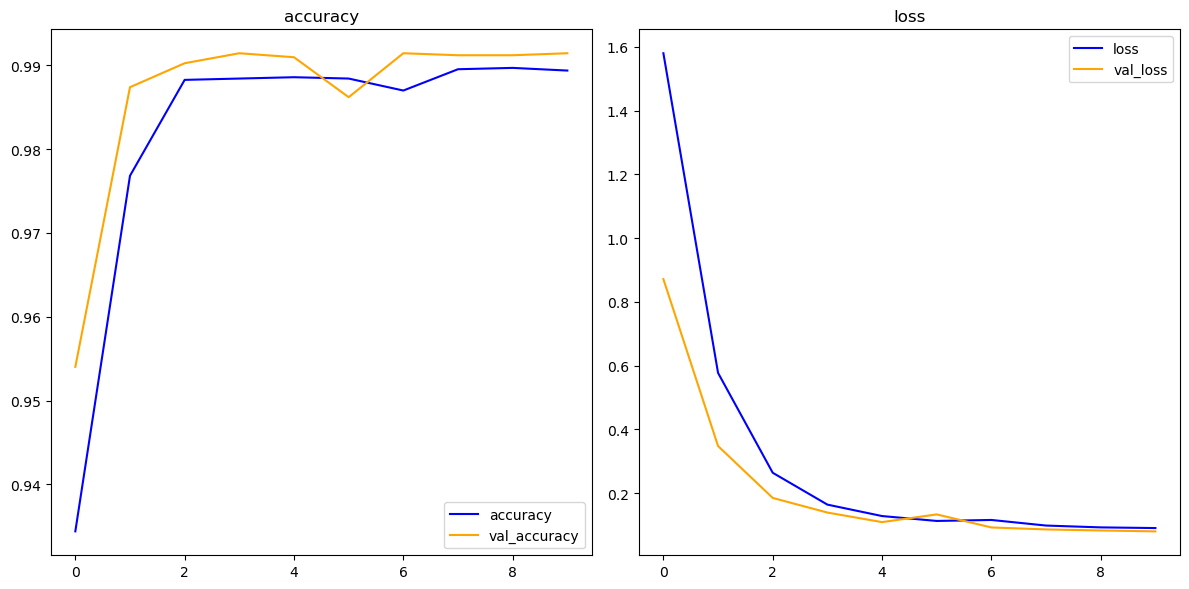

In [26]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.legend()
plt.title("accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.legend()
plt.title("loss")

plt.tight_layout()

In [27]:
score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07986754924058914
Test accuracy: 0.017048519104719162


In [28]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

132/132 [==============================] - 0s 975us/step
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 98.39%


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4004
           1       0.98      0.83      0.90       193

   micro avg       0.99      0.99      0.99      4197
   macro avg       0.98      0.92      0.95      4197
weighted avg       0.99      0.99      0.99      4197
 samples avg       0.99      0.99      0.99      4197



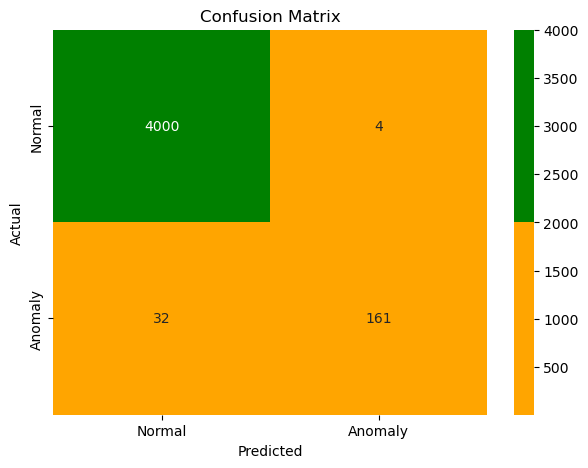

In [42]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)